# Starters

## Imports

In [56]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage.measure
from PIL import Image
import re
import time
from skimage.io import imsave, imread
# from skimage.util import img_as_ubyte
from scipy import ndimage
import deepcell
import deepcell.applications.cell_tracking
from deepcell.applications import Mesmer
from skimage import (
    color, data, color, io, filters, measure, morphology, segmentation
)
import cv2
from skimage import measure
# import torch
import glob
import seaborn as sns
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import feature
import math
import copy
import glob
import colorcet as cc
from collections import Counter
import ipynb
# import plotly.io
# import plotly.express as px

2022-06-18 14:52:39.407995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Define Functions

### General Functions

In [136]:
# For sorting lists
def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    l.sort(key=alphanum_key)

# Function for showing tifs quickly
def showtif(file, zstack=0, channel=0, verbose=True):
    if os.path.isfile(file):
        skimg = io.imread(file, plugin='tifffile')
    else:
        skimg = file
    if len(skimg.shape) == 2:
        img = skimg
    if len(skimg.shape) == 3:
        img = skimg[zstack]
    if len(skimg.shape) == 4:
        img = skimg[zstack, channel]
    if verbose == True:
        if len(skimg.shape) == 2:
            print(skimg.shape, "\n", "Single layer of size {} x {}".format(skimg.shape[0], skimg.shape[1]))
        else:
            print(skimg.shape, "\n", "Showing Z-stack {} of {}".format(zstack, skimg.shape[0]-1))
    plt.axis('off')
    a = plt.imshow(img, cmap='gray')
    return a

# Function for returning values from dictionary keys
def get_key(dict, val):
    if type(val) == float:
        for key, value in dict.items():
            if val == value:
                return key
        return "key doesn't exist"
    if type(val) == list:
        outkeys = []
        for i in val:
            for key, value in dict.items():
                if i == value:
                    outkeys.append(key)
        return outkeys

### My Functions

In [12]:
def interpZv4(labelfile, imagefile, zstart, zend, compare = True, savefigs = False):
    # Bring in the labels
    skimg = io.imread(labelfile, plugin='tifffile')
    startlab = skimg[zstart]
    endlab = skimg[zend]
    # Bring in the cell image
    imgin = io.imread(imagefile, plugin='tifffile')
    startim = imgin[zstart]
    endim = imgin[zend]

    diff = zend-zstart
    chunk = 1/diff

    # Distance Maps
    startdist = ndimage.distance_transform_cdt(startlab)
    enddist = ndimage.distance_transform_cdt(endlab)

    # Find the blob labels for the start and end images with watershed
    coords = peak_local_max(startdist, footprint=np.ones((50,50)))
    mask = np.zeros(startlab.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = measure.label(mask)
    labeledstart = watershed(startlab, markers, mask = startlab)

    coords = peak_local_max(enddist, footprint=np.ones((50,50)))
    mask = np.zeros(endlab.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = measure.label(mask)
    labeledend = watershed(endlab, markers, mask = endlab)

    # Consensus Regions and Conflict Regions
    andmap = np.logical_and(startlab, endlab) # intersection
    ormap = np.logical_or(startlab, endlab) # union
    conflictmap = np.logical_xor(ormap, andmap)
    ordist = ndimage.distance_transform_cdt(ormap)

    growing = cv2.subtract(endlab,startlab)==255
    shrinking = cv2.subtract(startlab, endlab)==255

    shrinkblobs = startdist*shrinking
    growblobs = enddist*growing

    outlabs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
    outims = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))

    newtifcounter = 0

    for i in range(diff-1):
        znew = i+1
        zstartdist = (diff-znew)
        zstartweight = (zstartdist)*chunk
        zendweight = (diff-zstartdist)*chunk

        shrinkmap = np.zeros(andmap.shape)
        for i in range(1,max(np.unique(labeledstart))+1):
            matrixspace = np.logical_and(shrinkblobs!=0,labeledstart==i)
            sortedvals = sorted(np.unique(shrinkblobs*matrixspace)[1:])
            if len(sortedvals) > 0:
                shrinkthresh = (np.max(sortedvals))*zstartweight
                positivepoints = np.logical_and(startdist>shrinkthresh, matrixspace)
                shrinkmap[positivepoints] = True
            else:
                continue

        growmap = np.zeros(andmap.shape)
        for i in range(1,max(np.unique(labeledend))+1):
            matrixspace =  np.logical_and(growblobs!=0,labeledend==i)
            sortedvals = sorted(np.unique(growblobs*matrixspace)[1:])
            if len(sortedvals) > 0:
                growthresh = (np.max(sortedvals))*zendweight
                positivepoints = np.logical_and(enddist>growthresh, matrixspace)
                growmap[positivepoints] = True
            else:
                continue

        combomap = np.logical_or(growmap,shrinkmap)
        newz = np.logical_or(andmap,combomap)
        outlabs[newtifcounter]=newz
        ###
        # Create an averaged image using the start and end weights
        intim = cv2.addWeighted(startim,zstartweight,endim,zendweight,0)
        # use the new z for the same level as a mask
        mask = newz.copy()
        maskedim = intim*mask
        outims[newtifcounter]=maskedim
        newtifcounter+=1

    # if compare:
    #         plt.figure(figsize=(10,15))
    #         for i in range(diff-1):
    #             zoffocus = i+1
    #             actual = skimg[zstart+zoffocus].astype(np.uint8)
    #             interpolated = outtifs[i].astype(np.uint8)
    #             dif = np.logical_xor(actual,interpolated)
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, 2)
    #             plt.title(f'Z-Stack {zstart} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zstart],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-5)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zstart+zoffocus],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-4)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Interpolated')
    #             plt.axis('off')
    #             plt.imshow(outtifs[i],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-3)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Difference')
    #             plt.axis('off')
    #             plt.imshow(dif, cmap = 'viridis')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-1)
    #             plt.title(f'Z-Stack {zend} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zend], cmap ='gray')
    #
    #         plt.tight_layout()
    #         if savefigs:
    #             plt.savefig(FIGDIR+"Interpolation_Comparison.png")

    return outlabs, outims

## Set Directories

In [3]:
SCRIPTDIR = os.path.realpath('./')
SCRIPTDIR = '/scratch/ns4964/lionnet/scripts/'

os.chdir(SCRIPTDIR)
os.chdir('../inputs/train3D/')
DATADIR = os.getcwd()

os.chdir(SCRIPTDIR)
os.chdir('../output/Interpolated/')
OUTDIR = os.getcwd()

os.chdir(SCRIPTDIR)

## Bring in Data

In [13]:
# Only pull folders from the data directory
os.chdir(DATADIR)
imgfolders = []
for file in os.listdir():
    if os.path.isdir(file):
        imgfolders.append(file)

sort_nicely(imgfolders)

# Create reference df for all images
imgdf = pd.DataFrame(imgfolders, columns=['imgfolder'])
imgdf['gappath'] = ''
imgdf['imagepath'] = ''
imgdf['labelpath'] = ''
imgdf['zlayers'] = ''
imgdf['x'] = ''
imgdf['y'] = ''

for index, row in imgdf.iterrows():
    indir = os.path.join(DATADIR, imgdf.iloc[index]['imgfolder'])
    imgdf.at[index, 'gappath'] = os.path.join(indir, 'gap.tif')
    imgdf.at[index, 'imagepath'] = os.path.join(indir, 'image.tif')
    imgdf.at[index, 'labelpath'] = os.path.join(indir, 'label.tif')
    im = imgdf['imagepath'][0]
    skimg = io.imread(im, plugin='tifffile')
    imgdf.at[index, 'zlayers'] = skimg.shape[0]
    imgdf.at[index, 'x'] = skimg.shape[1]
    imgdf.at[index, 'y'] = skimg.shape[2]
imgdf

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
3,C1-FB323A_CSC_Rd1_4,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
4,C1-FB323A_CSC_Rd1_5,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
5,C1-FB323A_CSC_Rd1_6,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
6,C1-FB323A_CSC_Rd1_7,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
7,C1-FB323A_CSC_Rd1_8,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
8,C1-FB323A_CSC_Rd1_9,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
9,C1-FB323A_CSC_Rd1_10,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [17]:
# Small DF to test loops
testdf = imgdf.loc[0:2].copy()
testdf = testdf.reset_index(drop=True)
testdf

,imgfolder,gappath,imagepath,labelpath,zlayers,x,y
0,C1-FB323A_CSC_Rd1_1,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
1,C1-FB323A_CSC_Rd1_2,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024
2,C1-FB323A_CSC_Rd1_3,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,/scratch/ns4964/lionnet/inputs/train3D/C1-FB32...,7,1024,1024


In [24]:
# Single image df
singledf = imgdf.loc[[2]].copy()
singledf = singledf.reset_index(drop=True)
singledf.loc[0]['imgfolder']

'C1-FB323A_CSC_Rd1_3'

# Laying Down the Idea

## Pieces

### Modified z-interpolation function

In [181]:
# Returns a stack determined by the distance between boundaries.
def interpZv5(mask_stack, image_stack, zstart, zend, compare = False, savefigs = False):
    # Bring in the labels
    skimg = mask_stack
    startlab = skimg[zstart]
    endlab = skimg[zend]
    # Bring in the cell image
    imgin = image_stack
    startim = imgin[zstart]
    endim = imgin[zend]

    diff = zend-zstart
    chunk = 1/diff

    # Distance Maps
    startdist = ndimage.distance_transform_cdt(startlab)
    enddist = ndimage.distance_transform_cdt(endlab)

    # Find the blob labels for the start and end images with watershed
    coords = peak_local_max(startdist, footprint=np.ones((50,50)))
    mask = np.zeros(startlab.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = measure.label(mask)
    labeledstart = watershed(startlab, markers, mask = startlab)

    coords = peak_local_max(enddist, footprint=np.ones((50,50)))
    mask = np.zeros(endlab.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = measure.label(mask)
    labeledend = watershed(endlab, markers, mask = endlab)

    # Consensus Regions and Conflict Regions
    andmap = np.logical_and(startlab, endlab) # intersection
    ormap = np.logical_or(startlab, endlab) # union
    conflictmap = np.logical_xor(ormap, andmap)
    ordist = ndimage.distance_transform_cdt(ormap)

    growing = cv2.subtract(endlab,startlab)==255
    shrinking = cv2.subtract(startlab, endlab)==255

    shrinkblobs = startdist*shrinking
    growblobs = enddist*growing

    outlabs = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))
    outims = np.empty((diff-1,skimg.shape[1],skimg.shape[2]))

    newtifcounter = 0

    for i in range(diff-1):
        znew = i+1
        zstartdist = (diff-znew)
        zstartweight = (zstartdist)*chunk
        zendweight = (diff-zstartdist)*chunk

        shrinkmap = np.zeros(andmap.shape)
        for i in range(1,max(np.unique(labeledstart))+1):
            matrixspace = np.logical_and(shrinkblobs!=0,labeledstart==i)
            sortedvals = sorted(np.unique(shrinkblobs*matrixspace)[1:])
            if len(sortedvals) > 0:
                shrinkthresh = (np.max(sortedvals))*(1-zstartweight)
                positivepoints = np.logical_and(startdist>shrinkthresh, matrixspace)
                shrinkmap[positivepoints] = True
            else:
                continue

        growmap = np.zeros(andmap.shape)
        for i in range(1,max(np.unique(labeledend))+1):
            matrixspace =  np.logical_and(growblobs!=0,labeledend==i)
            sortedvals = sorted(np.unique(growblobs*matrixspace)[1:])
            if len(sortedvals) > 0:
                growthresh = (np.max(sortedvals))*(1-zendweight)
                positivepoints = np.logical_and(enddist>growthresh, matrixspace)
                growmap[positivepoints] = True
            else:
                continue

        combomap = np.logical_or(growmap,shrinkmap)
        newz = np.logical_or(andmap,combomap)
        outlabs[newtifcounter]=newz
        ###
        # Create an averaged image using the start and end weights
        intim = cv2.addWeighted(startim,zstartweight,endim,zendweight,0)
        # use the new z for the same level as a mask
        mask = newz.copy()
        maskedim = intim*mask
        outims[newtifcounter]=maskedim
        newtifcounter+=1

    # if compare:
    #         plt.figure(figsize=(10,15))
    #         for i in range(diff-1):
    #             zoffocus = i+1
    #             actual = skimg[zstart+zoffocus].astype(np.uint8)
    #             interpolated = outtifs[i].astype(np.uint8)
    #             dif = np.logical_xor(actual,interpolated)
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, 2)
    #             plt.title(f'Z-Stack {zstart} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zstart],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-5)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zstart+zoffocus],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-4)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Interpolated')
    #             plt.axis('off')
    #             plt.imshow(outtifs[i],cmap='gray')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-3)
    #             plt.title(f'Z-Stack {zstart+zoffocus} Difference')
    #             plt.axis('off')
    #             plt.imshow(dif, cmap = 'viridis')
    #
    #             plt.subplot(outtifs.shape[0]+2, 3, ((zoffocus+2)*3)-1)
    #             plt.title(f'Z-Stack {zend} Actual')
    #             plt.axis('off')
    #             plt.imshow(skimg[zend], cmap ='gray')
    #
    #         plt.tight_layout()
    #         if savefigs:
    #             plt.savefig(FIGDIR+"Interpolation_Comparison.png")

    return outlabs, outims

In [34]:
# Specify the number of intermediate layers to generate first, then create a new stack with empty images at the interpolated layers

df = singledf
# Things needed for the function
intermediatelayers = 2
insize = df.iloc[0]['zlayers']
# Equation to find the size of the final stack after adding interpolated images
outsize = insize+((insize-1)*intermediatelayers)
outsize

19

In [57]:
# Use the intermediate size to identify the positions of the original images
x = range(0,np.max(outsize),intermediatelayers+1)
origpositions = []
for j in x:
    origpositions.append(j)
origpositions

[0, 3, 6, 9, 12, 15, 18]

In [64]:
# Create a stack and add the original images to the positions
## open loop
i = 0
imdata = df.loc[i]
maskfile = imdata.labelpath
imgname = imdata.imgfolder
imagefile = imdata.imagepath
stacks = df.iloc[i]['zlayers']
buffmask = np.empty((outsize,df.iloc[i]['x'],df.iloc[i]['y']))
buffims = np.empty((outsize,df.iloc[i]['x'],df.iloc[i]['y']))

buffmask.shape
buffims.shape

(19, 1024, 1024)

In [67]:
# showtif(buffims)

(7, 1024, 1024) 
 Showing Z-stack 1 of 7


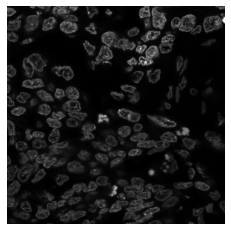

In [77]:
# Bring in an image
origimg = io.imread(imagefile, plugin='tifffile')
origmask = io.imread(maskfile, plugin='tifffile')
showtif(origimg)

In [78]:
# Apply each image to its corresponding position in the new stack
for j in range(len(origimg)):
    newpos = origpositions[j]
    buffims[newpos] = origimg[j]
    buffmask[newpos] = origmask[j]

(19, 1024, 1024) 
 Showing Z-stack 4 of 19


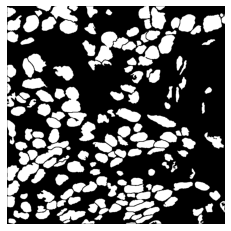

In [80]:
showtif(buffmask,zstack=3)

In [182]:
run = True # 72 seconds for one file
# run = False

if run:
    start_time = time.time()
    # Run the loop to generate intermediate masks and images
    for j in range(len(buffmask)):
        # Stop the loop once it reaches the final image
        if j == len(buffmask)-1:
            continue
        # Only use the original inputs to generate interpolations
        if j in origpositions:
            zstart = j
            # Find the index of the value in the original positions list to take the following original position
            startind = origpositions.index(j)
            zend = origpositions[startind+1]
            intpmask, intpim = interpZv5(mask_stack=buffmask,image_stack=buffims,zstart=zstart,zend=zend)

            # for interpolated images that are only one layer deep (diff=1), shape would be (1024,1024)
            if len(intpim.shape) == 3:
                # Move through the new stack and assign each layer to its correct position
                for layer in range(intpim.shape[0]):
                    # buffims
                    newpos = j+(layer+1)
                    buffims[newpos] = intpim[layer]
                    buffmask[newpos] = intpmask[layer]
            else:
                newpos = j+1
                buffims[newpos] = intpim
                buffmask[newpos] = intpmask
    print("--- %s seconds for %s file(s) ---" % (round((time.time() - start_time),0),len(df)))

--- 77.0 seconds for 1 file(s) ---


In [176]:
# showtif(intpmask, zstack=0)

In [177]:
# showtif(buffmask, zstack = 1)

In [183]:
saveims = True
saveims = False

if saveims:
    os.chdir(OUTDIR)
    imgoutname = imgname+"-"+"image-"+"addedinterplayers-"+str(intermediatelayers)+'.tiff'
    maskoutname = imgname+"-"+"mask-"+"addedinterplayers-"+str(intermediatelayers)+'.tiff'

    pilimages = []
    for i in range(buffmask.shape[0]):
        new = Image.fromarray(buffmask[i])
        pilimages.append(new)
    pilimages[0].save(maskoutname,format='TIFF',save_all=True,append_images=pilimages[1:])

    interpimgtiff = []
    for i in range(buffims.shape[0]):
        newimg = Image.fromarray(buffims[i])
        newimg = newimg.convert("RGB")
        interpimgtiff.append(newimg)
    interpimgtiff[0].save(imgoutname,format='TIFF',save_all=True,append_images=interpimgtiff[1:])
    # print(imgoutname)
    # print(maskoutname)


# Full Loop

In [191]:
run = True
run = False

saveims = True
saveims = False

df = singledf
df=testdf
df=imgdf

if run:
    start_time = time.time()
    layerstotest = [1,2,3]

    for intermeds in layerstotest:
        # Set the desired layers to generate between each original image
        intermediatelayers = intermeds

        for i in df.index:
            insize = df.iloc[0]['zlayers']

            # Equation to find the size of the final stack after adding interpolated images
            outsize = insize+((insize-1)*intermediatelayers)

            # Use the intermediate size to identify the positions of the original images
            x = range(0,np.max(outsize),intermediatelayers+1)
            origpositions = []
            for j in x:
                origpositions.append(j)

            # Create a stack and add the original images to the positions
            imdata = df.loc[i]
            maskfile = imdata.labelpath
            imgname = imdata.imgfolder
            imagefile = imdata.imagepath
            stacks = df.iloc[i]['zlayers']
            buffmask = np.empty((outsize,df.iloc[i]['x'],df.iloc[i]['y']))
            buffims = np.empty((outsize,df.iloc[i]['x'],df.iloc[i]['y']))

            # Bring in an image
            origimg = io.imread(imagefile, plugin='tifffile')
            origmask = io.imread(maskfile, plugin='tifffile')

            # Apply each image to its corresponding position in the new stack
            for j in range(len(origimg)):
                newpos = origpositions[j]
                buffims[newpos] = origimg[j]
                buffmask[newpos] = origmask[j]

            # Run the loop to generate intermediate masks and images
            for j in range(len(buffmask)):
                # Stop the loop once it reaches the final image
                if j == len(buffmask)-1:
                    continue
                # Only use the original inputs to generate interpolations
                if j in origpositions:
                    zstart = j
                    # Find the index of the value in the original positions list to take the following original position
                    startind = origpositions.index(j)
                    zend = origpositions[startind+1]
                    intpmask, intpim = interpZv5(mask_stack=buffmask,image_stack=buffims,zstart=zstart,zend=zend)

                    # for interpolated images that are only one layer deep (diff=1), shape would be (1024,1024)
                    if len(intpim.shape) == 3:
                        # Move through the new stack and assign each layer to its correct position
                        for layer in range(intpim.shape[0]):
                            # buffims
                            newpos = j+(layer+1)
                            buffims[newpos] = intpim[layer]
                            buffmask[newpos] = intpmask[layer]
                    else:
                        newpos = j+1
                        buffims[newpos] = intpim
                        buffmask[newpos] = intpmask
            # Save the entire stack after it is created
            if saveims:
                os.chdir(OUTDIR)
                imgoutname = imgname+"-"+"image-"+"addedinterplayers-"+str(intermediatelayers)+'.tiff'
                maskoutname = imgname+"-"+"mask-"+"addedinterplayers-"+str(intermediatelayers)+'.tiff'

                pilimages = []
                for j in range(buffmask.shape[0]):
                    new = Image.fromarray(buffmask[j])
                    pilimages.append(new)
                pilimages[0].save(maskoutname,format='TIFF',save_all=True,append_images=pilimages[1:])

                interpimgtiff = []
                for j in range(buffims.shape[0]):
                    newimg = Image.fromarray(buffims[j])
                    newimg = newimg.convert("RGB")
                    interpimgtiff.append(newimg)
                interpimgtiff[0].save(imgoutname,format='TIFF',save_all=True,append_images=interpimgtiff[1:])
    print("--- %s seconds for %s file(s) ---" % (round((time.time() - start_time),0),len(df)))

--- 3623.0 seconds for 23 file(s) ---
